In [48]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

class GANet :
    
    """This Class implements the GA-Net Algorithm For Community Detection"""
    
    best_population = None
    
    def __init__(self,G,n_generation=5,population_size = 6,n_best_ind= 3,mean_order=2):
        self.G = G
        self.population_size = population_size
        self.n_best_ind = n_best_ind
        self.mean_order = mean_order
        self.N = G.shape[0]
        self.n_generation = n_generation
        
    def decode(self,chrom):
        """
        Decodes The Individual
        Assign Each Node To A Cluster
        Returns An Adjancy Matrice For Each sub-Graph (Cluster) And The Cluster Assignment
        """
        cc=0
        clusterAssignment=[None]*len(chrom)
        previous=[None]*len(chrom)
        for i in range(len(chrom)):
            ctr=0
            if clusterAssignment[i]==None:
                clusterAssignment[i]=cc
                neighbor=chrom[i]
                previous[ctr]=i
                ctr+=1
                while clusterAssignment[neighbor]==None:
                    previous[ctr]=neighbor
                    clusterAssignment[neighbor]=cc
                    neighbor=chrom[neighbor]
                    ctr+=1
                if clusterAssignment[neighbor] != cc:
                    ctr-=1
                    while ctr >= 0:
                        clusterAssignment[previous[ctr]]=clusterAssignment[neighbor]
                        ctr-=1
                else:
                    cc+=1
        
        clusterAssignment = np.array(clusterAssignment)
        clusters = np.unique(clusterAssignment)
        sub_adjancies = []
        
        for c in clusters :
            indices = np.argwhere(clusterAssignment == c)
            size = len(indices)
            indices = indices.reshape(size)
            sub_adjancies.append(np.take(np.take(self.G,indices,axis=0),indices,axis=1))
        
        return (sub_adjancies,clusterAssignment)
            
        
    def fitness(self,individual) :
        """
        Returns The Community score Of The 
        Components On Which The Graph Is Partitioned
        
        """
        partition,_ = self.decode(individual)
        Q = []
        for part in partition :
            vs = np.sum(part)
            shape = np.shape(part)
            aiJ = np.sum(part,axis= 1)/ shape[1]
            M_s = np.sum(aiJ**self.mean_order) / shape[0]
            Q.append(M_s * vs)
            
        return np.sum(np.array(Q))
    
    def fitness_pop(self,pop) :
        """
        Returns The Fitness Of The Population
        """
        score = []
        for p in pop :
            score.append(self.fitness(p))
            
        return np.array(score)
    
    def bes_pop(self,pop):
        """
        Returns The Individual With Best Fitness score
        """
        fitness = self.fitness_pop(pop)
        best_fit = np.where(fitness == np.max(fitness))
        return pop[best_fit[0][0]]
    
    def initialize(self) :
        """
        Create The First Generation
        """
        individuals = []
        G = self.G
        # np.random.seed(123)
        
        
        for i in range(self.population_size) :
            individual =np.random.randint(self.N,size=self.N)
            for j in range(self.N):
                if(G[j,individual[j]] == 0):
                    neighbors = np.array(np.where(G[j,:] == 1))
                    n_neighbor = len(neighbors[0])
                    neighbors = neighbors.reshape(n_neighbor)
                    i_n = np.random.randint(n_neighbor)
                    individual[j] = neighbors[i_n]
                    
            individuals.append(individual)
            
        return np.array(individuals)
        
    def select_mating_tool(self,fitness_score,population):
        """
        Returns The Best Parents According To The Fitness Values
        """
        num_parents = self.n_best_ind
        parents = np.zeros((num_parents, population.shape[1]))
        
        for i in range(num_parents):
            max_fitness_idx = np.where(fitness_score == np.max(fitness_score))
            max_fitness_idx = max_fitness_idx[0][0]
            parents[i, :] = population[max_fitness_idx, :]
            fitness_score[max_fitness_idx] = -99999999999
        
        return parents.astype(int)
    
    def uniform_crossover(self,parents) :
        """
        Returns Next Generation Children
        """
        offspring_size = parents.shape
        offspring = np.empty(offspring_size)
        crossover_point = np.uint8(offspring_size[1]/2)

        for k in range(offspring_size[0]):
         # Index of the first parent to mate.
            parent1_idx = k%parents.shape[0]
         # Index of the second parent to mate.
            parent2_idx = (k+1)%parents.shape[0]
         # The new offspring will have its first half of its genes taken from the first parent.
            offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
         # The new offspring will have its second half of its genes taken from the second parent.
            offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
        return offspring.astype(int)
    
    def mutate(self,pop):
      """Mutate Each Chromosom"""

      G = self.G

      for idx in range(pop.shape[0]):

        neighbors = np.array(np.where(G[4,:] == 1))
        n_neighbor = len(neighbors[0])
        neighbors = neighbors.reshape(n_neighbor)
        i_n = np.random.randint(n_neighbor)
        pop[idx, 4] = neighbors[i_n]

      return pop

    def run(self) :
        """
        Launch The Algorithm
        """
        population = self.initialize()
        for generation in range(self.n_generation):
            fitness = self.fitness_pop(population)
            parents = self.select_mating_tool(fitness,population)
            cross_over = self.uniform_crossover(parents)
            mutated = self.mutate(cross_over)
            population[0:parents.shape[0], :] = parents
            population[parents.shape[0]:, :] = mutated
            
        self.best_population = self.bes_pop(population)
    
    def get_communitites(self):
        """
        Returns The Communtites found
        """
        _,communitites = self.decode(self.best_population)
        return communitites

def draw_communities(G,A, node_size=30, alpha=1, k=None, randomized=False):
    ganet = GANet(G=A)
    ganet.run()
    partition = ganet.get_communitites()
    print("Clusters :",partition)
    print("Best Chromosom :",ganet.best_population)
    print("Fitness score :",ganet.fitness(ganet.best_population))

    community_map = {}
    for node, community in enumerate(partition):
        community_map[node] = community

    cmap = plt.get_cmap("jet")
    pos = nx.spring_layout(G)
    indexed = [community_map.get(node) for node in G]
    plt.axis("off")
    plt.figure(3,figsize=(12,12))
    nx.draw_networkx_nodes(G, pos=pos, cmap=cmap, node_color=indexed, node_size=500, alpha=alpha,label=[str(i) for i in list(G.nodes())])
    nx.draw_networkx_edges(G, pos=pos, alpha=0.2)

    


In [2]:
def get_edge_list(file_name):
    # Open the file and read its contents
    with open(file_name) as file:
        lines = file.readlines()

    # Remove lines that are comments (start with "#")
    lines = [line for line in lines if '#' not in line]

    # Convert each line to a pair of integers
    edge_list = []
    for line in lines:
        edge = tuple(map(int, line.strip().split()))
        edge_list.append(edge)
    
    return edge_list

def get_undirected_graph_info(file_name):
    my_edge_list = get_edge_list(file_name)
    undirected_graph = nx.Graph()
    undirected_graph.add_edges_from(my_edge_list)
    file_info = file_name.split(os.sep)[-1].split('_')[0]
    str_list = [file_info, 'nodes num:' + str(undirected_graph.number_of_nodes()), 'edges num:'
                + str(undirected_graph.number_of_edges())]
    print (' | '.join(str_list))


def get_dir_info(dir_name):
    my_walk = os.walk(dir_name)
    my_root, sub_root_list, file_list = list(my_walk)[0]
    path_list = map(lambda ele: my_root + os.sep + ele, file_list)
    for my_path in path_list:
        get_undirected_graph_info(my_path)


Clusters : [0 0 0 0 1 1 1 0 0 2 1 0 0 0 1 0 2 0 3 3 3 3 2 4 4 0 3 2 2 2 2 2 2 2]
Best Chromosom : [17  0  1  7 10 14 14  2  2 33  5  1  3  3  5  1 33  1 26 21 18 20 33 24
 23  0 18 30 33 27 33 33 27 32]
Fitness score : 18.686944444444443


C:\Users\Nur\AppData\Local\Temp\ipykernel_13436\2558240501.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).toarray()


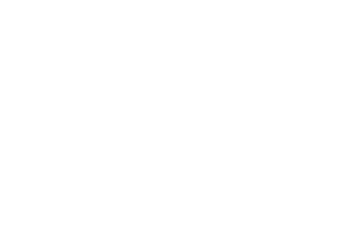

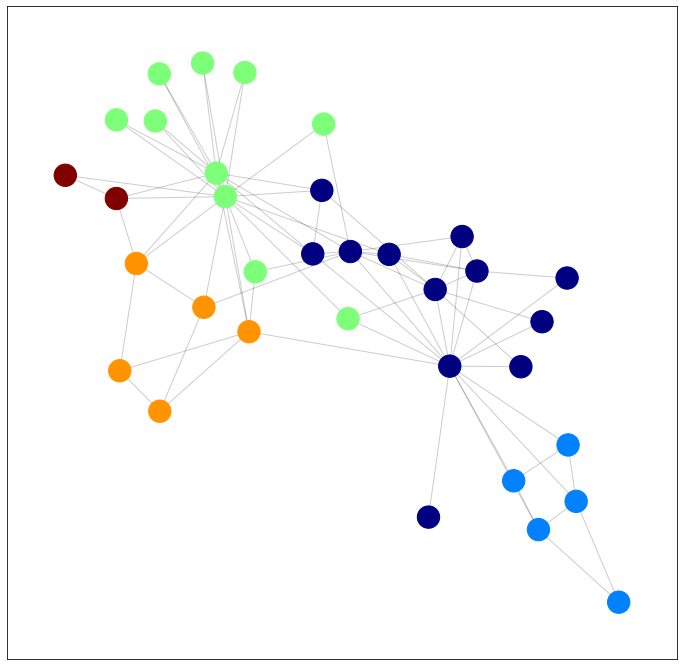

In [55]:
dataset = 'karate.txt'
edgeList = get_edge_list(dataset)
G = nx.Graph()
G.add_edges_from(edgeList)
A = nx.adjacency_matrix(G).toarray()

G = nx.Graph(A)
draw_communities(G,A)



# G = nx.ring_of_cliques(8, 4)
# # A = nx.to_numpy_array(G).astype(int)
# A = nx.adjacency_matrix(G).toarray()
# draw_communities(G,A)

# G = nx.karate_club_graph()
# # A = nx.to_numpy_array(G).astype(int)
# A = nx.adjacency_matrix(G).toarray()
# draw_communities(G,A)